In [1]:
import numpy as np
import IPython.display
import librosa
import librosa.display
import matplotlib.pyplot as plt
import os
import shutil
from random import shuffle
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from keras.utils import np_utils
%matplotlib inline

Using TensorFlow backend.


In [2]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

def read_png(path):
    img = mpimg.imread(path)
    return rgb2gray(img)

### Feature File Manager

In [16]:
class SpectrogramFeatureFileManager(object):
    def __init__(self, seconds=10, skip_augment=False):
        self.seconds = seconds
        self.skip_augment = skip_augment

    def get_file_credentials(self, path):
        values = path.split('#')[-1].split('.')[0]
        sr, winlen, winstep = map(int, values.split('='))
        return sr, winlen, winstep

    def load(self, path):
        """ Return list of objects, ectracted from given file """
        if self.skip_augment and u'#AUG#' in path:
            return []

        file_data = read_png(path)

        sr, winlen, winstep = self.get_file_credentials(path)
        one_sec_count = sr / winstep
        chunk_size = one_sec_count * self.seconds

        height, width = file_data.shape
        
        # print file_data.shape, width, sr, winlen, winstep
        # print one_sec_count, chunk_size
        
        if width < chunk_size:
            return []
        
        result = []
        
        chunks = (width + chunk_size - 1) / chunk_size
        for chunk in xrange(chunks):
            start = (chunk * chunk_size)
            end = min(file_data.shape[1], (chunk + 1) * chunk_size)
            
            if end - start < chunk_size:
                break

            result.append(file_data[:, start:end])

        return result

In [4]:
# path = '/home/kolegor/Study/Master/Work/data/features/spectrogram/ab_Russian/train/Leo-Tolstoy-Detstvo-RUSSIAN-24-V_posteli_64kb.mp3.wav.chunk018.png#24000=360=600.png'
# manager = SpectrogramFeatureFileManager(seconds=3)
# asd = manager.load(path)
# len(asd)
# librosa.display.specshow(read_png(path), sr=22050, x_axis='time', y_axis='mel')
# plt.show()
# for a in asd:
#     librosa.display.specshow(a, sr=22050, x_axis='time', y_axis='mel')
#     plt.show()

### Dataset manager

In [17]:
class FolderIterator(object):
    PATH_TEMPLATE = '/home/kolegor/Study/Master/Work/data/features/spectrogram/{language}/{dataset}/'

    def __init__(self, language, dataset, uid):
        self.language = language
        self.dataset = dataset
        self.uid = uid

        self.path = self.PATH_TEMPLATE.format(language=language, dataset=dataset)
    
    def get_data(self):
        x = [os.path.join(self.path, filename) for filename in os.listdir(self.path)]
        y = [self.uid for _ in xrange(len(x))]
        return x, y

In [37]:
class Dataset(object):
    def __init__(self, folder_iterators, need_shuffle=True, manager=None):
        self.folders = folder_iterators
        
        self.manager = manager
        if self.manager is None:
            self.manager = SpectrogramFeatureFileManager(
                seconds=5,
                skip_augment=False
            )
        
        self.size_by_language = dict()
        
        self.all_x = []
        self.all_y = []
        
        for folder in self.folders:
            x, y = folder.get_data()
            if len(x) != len(y):
                raise Exception('What the hell?')
            
            self.all_x.extend(x)
            self.all_y.extend(y)
            self.size_by_language[folder.language] = len(x)
        
        if shuffle:
            combined = zip(self.all_x, self.all_y)
            shuffle(combined)
            self.all_x, self.all_y = zip(*combined)
        
        self.classes = len(set(self.all_y))
        self.size = len(self.all_x)

    def one_sample(self):
        qwe = []
        while not qwe:
            qwe = self.manager.load(self.all_x[0])
            if qwe:
                qwe = qwe[0]
                break
        return qwe


def dataset_iterator(dataset, chunk_size, as_np=False, extend=True, y_categorical=True, iters=10):
    for _ in xrange(iters):
        cur_chunk_x = []
        cur_chunk_y = []

        for filepath, uid in zip(dataset.all_x, dataset.all_y):
            loaded = dataset.manager.load(filepath)

            cur_chunk_x.extend(loaded)
            cur_chunk_y.extend([uid for _ in xrange(len(loaded))])

            if len(cur_chunk_x) >= chunk_size:
                to_return_x = cur_chunk_x[:chunk_size]
                to_return_y = cur_chunk_y[:chunk_size]

                cur_chunk_x = cur_chunk_x[chunk_size:]
                cur_chunk_y = cur_chunk_y[chunk_size:]

                if as_np:
                    to_return_x = np.array(to_return_x)
                    to_return_y = np.array(to_return_y)

                if extend:
                    to_return_x = to_return_x.reshape(to_return_x.shape + (1,))

                if y_categorical:
                    to_return_y = np_utils.to_categorical(to_return_y, dataset.classes)

                yield to_return_x, to_return_y


def load_all_dataset(dataset, as_np=False, extend=True, y_categorical=True):
    all_x = []
    all_y = []
    
    iterator = dataset_iterator(dataset, 32, as_np=False, extend=False, y_categorical=False)
    for x, y in iterator:
        all_x.extend(x)
        all_y.extend(y)
        
    all_x = np.array(all_x)
    all_y = np.array(all_y)
    
    if as_np:
        all_x = np.array(all_x)
        all_y = np.array(all_y)

    if extend:
        all_x = all_x.reshape(all_x.shape + (1,))

    if y_categorical:
        all_y = np_utils.to_categorical(all_y, dataset.classes)

    return all_x, all_y

In [38]:
def get_languages_dataset(languages):
    language_to_uid = dict((b, a) for a, b in enumerate(languages))
    train = Dataset([FolderIterator(language, 'train', language_to_uid[language]) for language in languages])
    test = Dataset([FolderIterator(language, 'test', language_to_uid[language]) for language in languages])
    dev = Dataset([FolderIterator(language, 'dev', language_to_uid[language]) for language in languages])
    return train, test, dev, language_to_uid

In [39]:
def print_languages_info(train_ds, test_ds, dev_ds):
    print u'Languages: [{}]'.format(u' # '.join(train_ds.size_by_language.keys()))
    print u'Classes: {}'.format(train_dataset.classes)
    print u'Sizes: (train/test/dev): {}/{}/{}'.format(train_ds.size, test_ds.size, dev_ds.size)

In [40]:
languages = ['ab_Portuguese', 'ab_Russian', 'ab_English', 'ab_French', 'ab_German']
train_dataset, test_dataset, dev_dataset, language_to_uid = get_languages_dataset(languages)
print_languages_info(train_dataset, test_dataset, dev_dataset)

Languages: [ab_Russian # ab_Portuguese # ab_German # ab_French # ab_English]
Classes: 5
Sizes: (train/test/dev): 45429/12992/6516


In [41]:
# dev_X, dev_Y = load_all_dataset(dev_dataset)

### Model build

In [42]:
def get_model(train_ds):
    sample = train_ds.one_sample()
    input_shape = (sample.shape[0], sample.shape[1], 1)
    print input_shape
    
    pool_size=(2, 2)

    model = Sequential()
    model.add(Conv2D(32, (7, 7), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=pool_size))
    model.add(Conv2D(64, (5, 5), activation='relu'))
    model.add(MaxPooling2D(pool_size=pool_size))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=pool_size))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=pool_size))
    
    # print model.summary()
    # model.add(Conv2D(256, (3, 3), activation='relu'))
    # model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dense(train_ds.classes, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [43]:
model = get_model(train_dataset)

(128, 200, 1)


In [44]:
def fit(model, X_train=None, Y_train=None, X_dev=None, Y_dev=None):
    batch_size = 32
    epochs = 4
    
    if X_train is None and Y_train is None:
        print 'Loading train data'
        X_train, Y_train = load_all_dataset(train_dataset)
    
    if X_dev is None and Y_dev is None:
        print 'Loading dev data'
        X_dev, Y_dev = load_all_dataset(dev_dataset)

    return model.fit(
        x=X_train,
        y=Y_train,
        batch_size=batch_size,
        epochs=epochs,
        validation_data=(X_dev, Y_dev),
    )


def fit_generator(model):
    batch_size = 32
    epochs = 4

    model.fit_generator(
        dataset_iterator(train_dataset, batch_size, as_np=True, extend=True),
        steps_per_epoch=len(train_dataset.all_x) / batch_size,
        epochs=epochs,
        validation_data=dataset_iterator(dev_dataset, batch_size, as_np=True, extend=True),
        validation_steps=len(dev_dataset.all_x) / batch_size,
    )

    return model

In [45]:
# print 'Loading train data'
# X_train, Y_train = load_all_dataset(train_dataset)
# print 'Loading dev data'
# X_dev, Y_dev = load_all_dataset(dev_dataset)

In [46]:
# _ = fit(model, X_train=X_train, Y_train=Y_train, X_dev=X_dev, Y_dev=Y_dev)
_ = fit_generator(model)

Epoch 1/4
1419/1419 [==============================] - 5687s 4s/step - loss: 0.4233 - acc: 0.8370 - val_loss: 3.0405 - val_acc: 0.5762
Epoch 2/4
1419/1419 [==============================] - 5266s 4s/step - loss: 0.1159 - acc: 0.9614 - val_loss: 3.1389 - val_acc: 0.5513
Epoch 3/4
1419/1419 [==============================] - 5178s 4s/step - loss: 0.0742 - acc: 0.9752 - val_loss: 2.5753 - val_acc: 0.6113
Epoch 4/4
1419/1419 [==============================] - 5163s 4s/step - loss: 0.0564 - acc: 0.9814 - val_loss: 3.3037 - val_acc: 0.5399


In [ ]:
print 'Loading train data'
X_test, Y_test = load_all_dataset(test_dataset)

Loading train data


In [47]:
model.evaluate(x=X_test, y=Y_test)

NameError: name 'X_test' is not defined

## Experiment results

#### 1

languages = ['ab_Portuguese', 'ab_Russian', 'ab_English', 'ab_French', 'ab_German']
seconds = 5, skip_augment = False

Epoch 1/4
1419/1419 [==============================] - 5687s 4s/step - loss: 0.4233 - acc: 0.8370 - val_loss: 3.0405 - val_acc: 0.5762
Epoch 2/4
1419/1419 [==============================] - 5266s 4s/step - loss: 0.1159 - acc: 0.9614 - val_loss: 3.1389 - val_acc: 0.5513
Epoch 3/4
1419/1419 [==============================] - 5178s 4s/step - loss: 0.0742 - acc: 0.9752 - val_loss: 2.5753 - val_acc: 0.6113
Epoch 4/4
1419/1419 [==============================] - 5163s 4s/step - loss: 0.0564 - acc: 0.9814 - val_loss: 3.3037 - val_acc: 0.5399


### Plot

In [82]:
def plot(acc_train, acc_val, acc_test, title):
    N = len(acc_train) + 2
    ticks = [u'Epoch {}'.format(i) for i in xrange(len(acc_train_1))]
    ticks += [u'', u'Test']
    
    acc_train += [0, acc_test]
    acc_val += [0, 0]

    ind = np.arange(N)  # the x locations for the groups
    width = 0.35       # the width of the bars

    fig, ax = plt.subplots(figsize=(15, 6))
    rects1 = ax.bar(ind, acc_train, width)
    rects2 = ax.bar(ind + width, acc_val, width)

    # add some text for labels, title and axes ticks
    ax.set_ylabel('Accuracy')
    ax.set_title(title, fontsize=15)
    ax.set_xticks(ind + width / 2)
    ax.set_xticklabels((ticks))
    
    def autolabel(rects):
        """
        Attach a text label above each bar displaying its height
        """
        for rect in rects:
            height = rect.get_height()
            if height == 0.0:
                continue
            ax.text(rect.get_x() + rect.get_width() / 2, height, '%.3f' % height, ha='center', va='bottom', fontsize=13)

    autolabel(rects1)
    autolabel(rects2)

    ax.legend((rects1[0], rects2[0]), ('Train or test', 'Validation'), loc=4, prop={'size': 20})

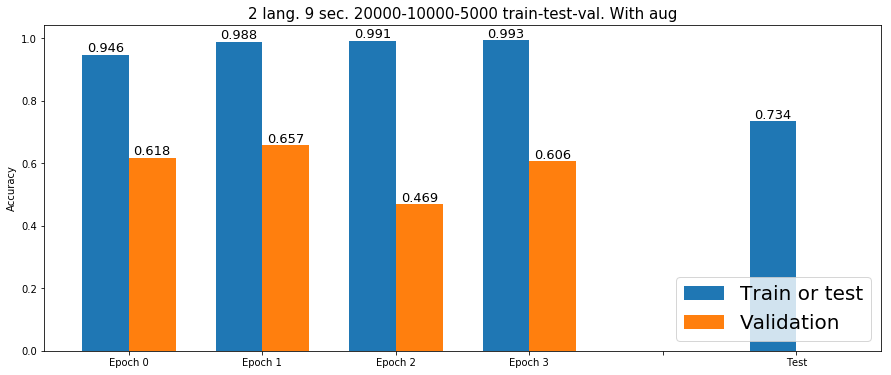

In [83]:
acc_train_1 = [0.9464, 0.9881, 0.9914, 0.9934]
acc_val_1 = [0.6178, 0.6566, 0.4691, 0.6056]
acc_test_1 = 0.7344
title_1 = u'2 lang. 9 sec. 20000-10000-5000 train-test-val. With aug'
plot(acc_train_1, acc_val_1, acc_test_1, title_1)

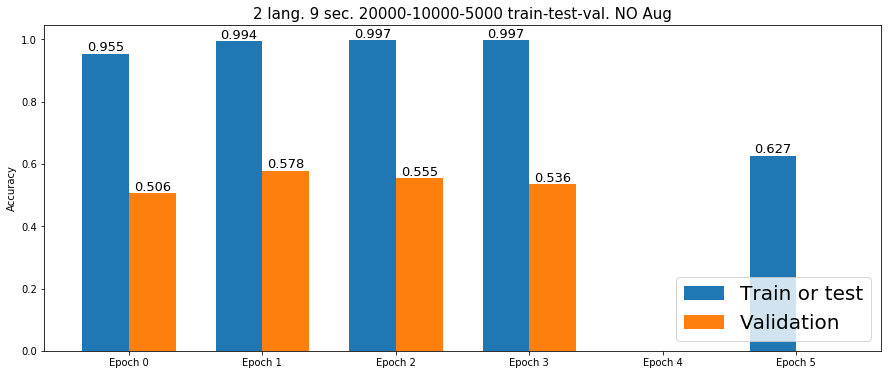

In [84]:
acc_train_2 = [0.9546, 0.9942, 0.9967, 0.9974]
acc_val_2 = [0.5064, 0.5776, 0.5547, 0.5356]
acc_test_2 = 0.6269
title_2 = u'2 lang. 9 sec. 20000-10000-5000 train-test-val. NO Aug'
plot(acc_train_2, acc_val_2, acc_test_2, title_2)

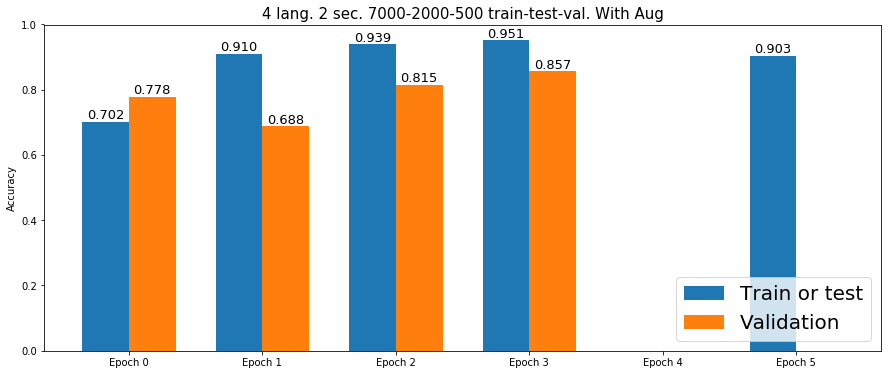

In [85]:
acc_train_3 = [0.7020, 0.9098, 0.9388, 0.9513]
acc_val_3 = [0.7777, 0.6875, 0.8150, 0.8568]
acc_test_3 = 0.9033
title_3 = u'4 lang. 2 sec. 7000-2000-500 train-test-val. With Aug'
plot(acc_train_3, acc_val_3, acc_test_3, title_3)

In [86]:
acc_4_all_train = [0.9317, 0.9617, 0.9802]
acc_4_all_val = [0.5655, 0.6598, 0.6546]
acc_4_all_test = [0.6533, 0.6872, 0.6766]

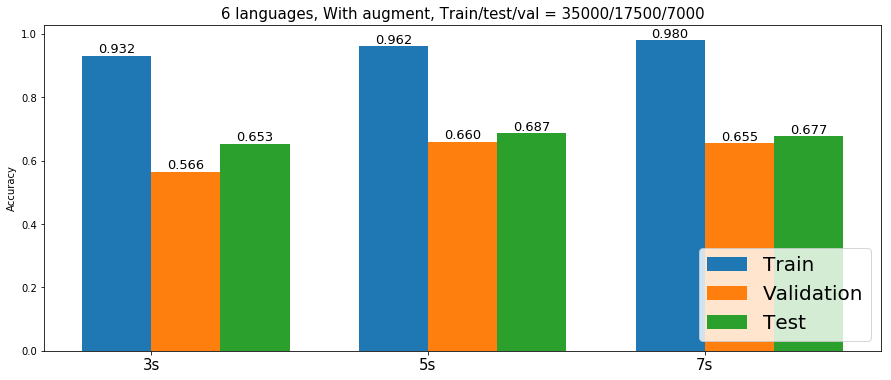

In [99]:
N = len(acc_4_all_train)
ticks = ['3s', '5s', '7s']

ind = np.arange(N)  # the x locations for the groups
width = 0.25       # the width of the bars

fig, ax = plt.subplots(figsize=(15, 6))
rects1 = ax.bar(ind, acc_4_all_train, width)
rects2 = ax.bar(ind + width, acc_4_all_val, width)
rects3 = ax.bar(ind + 2 * width, acc_4_all_test, width)

# add some text for labels, title and axes ticks
ax.set_ylabel('Accuracy')
ax.set_title('6 languages, With augment, Train/test/val = 35000/17500/7000', fontsize=15)
ax.set_xticks(ind + width / 2)
ax.set_xticklabels((ticks))
plt.xticks(fontsize=15)

def autolabel(rects):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        if height == 0.0:
            continue
        ax.text(rect.get_x() + rect.get_width() / 2, height, '%.3f' % height, ha='center', va='bottom', fontsize=13)

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

ax.legend((rects1[0], rects2[0], rects3[0]), ('Train', 'Validation', 'Test'), loc=4, prop={'size': 20})